POINT (0 370)


<Axes: >

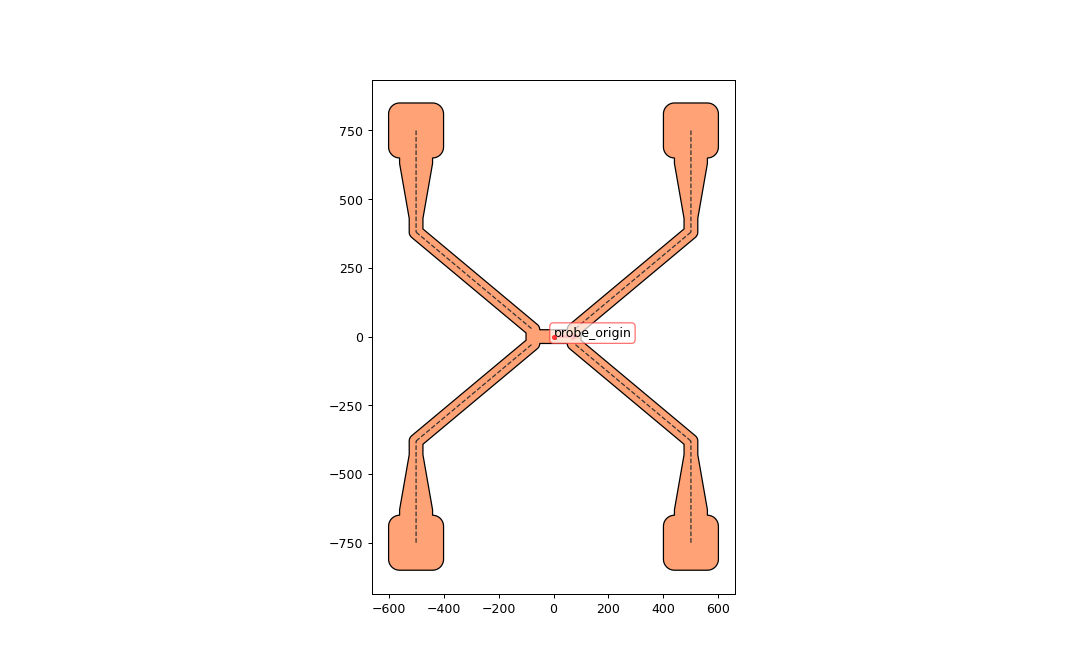

In [1]:
import sys
import numpy as np

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from shapely import affinity as aff, intersects, intersects_xy, line_merge, box, intersection 

import matplotlib
from zeroheliumkit import GeomCollection, SpiralInductor
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_DXF, Reader_GDS, Reader_Pickle

from zeroheliumkit import Structure, Entity, Anchor, SuperStructure, GeomCollection, Taper, MultiAnchor, ArbitraryLine, Skeletone, Fillet
from zeroheliumkit import Rectangle, Meander, MeanderHalf, Square, StraightLine, Circle
from zeroheliumkit.src.utils import midpoint, round_polygon
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_Pickle
from zeroheliumkit.helpers.resonator_calc import CPW_params

# no need if zeroheliumkit is installed from github
sys.path.insert(1, "/Volumes/EeroQ/lib/zeroheliumkit-dev/")   

%matplotlib widget
%config InlineBackend.figure_format='retina'
plot_config = {"wafer": LIGHTGRAY,
               "bottom": YELLOW2,
               "gnd": BLUE,
               "top": ORANGE,
               "etch": VIOLET,
               "open": GREEN,
               "air": (GRAY,0.7),
               "skeletone": DARKGRAY,
               "anchors": RED}

layer_thickness_config = {
    "top": 3,
    "gnd": 5
}



circle_radius = 50800
pad_size = 200
spacing = 1000
offset = 250
width = 50
width1 = 50
width2 = 25
width3 = 10
length = 200
connectorThickness = 50

taper_info = {
    "top": (pad_size-80, connectorThickness)    # layer2: starts at width 200, narrows to 50
}

def clearAnchors(object):
    for anc in object.anchors.labels:
        object.remove_anchor(anc)

def remakeAnchor(object: Structure, AnchorName: str, position: tuple, direction: float):
    if object.get_anchor(AnchorName) == None:
        object.add_anchor(Anchor(position,direction,AnchorName))
    else:
        object.remove_anchor(AnchorName)
        object.add_anchor(Anchor(position,direction,AnchorName))



quarterProbe = Structure()
remakeAnchor(quarterProbe,"origin",(0,0),0)
remakeAnchor(quarterProbe,"test_loc",(500-length/2,725),0)



pad = Structure()
pad.add_layer("top", round_polygon(Square(pad_size), 40))
remakeAnchor(pad,"o",(0,0),0)
remakeAnchor(pad,"tm",(0,0),90)

quarterProbe.append(pad,anchoring=("origin","o"),direction_snap=True)

connectorTaper = Taper(pad_size,taper_info,alabel=("a1","a2"))

testQuarter = Structure()
testQuarter.add_layer("top",Rectangle(length/2,width/2))
remakeAnchor(testQuarter,"bottom_left",(-length/4,-width/4),0)
remakeAnchor(testQuarter,"top_right",(length/4,width/4),0)
remakeAnchor(testQuarter,"attach_point",(-length/4+connectorThickness/2,-width/4),0)

quarterProbe.append(connectorTaper,anchoring=("tm","a1"),direction_snap=True,remove_anchor="tm")
quarterProbe.append(testQuarter,anchoring=("test_loc","bottom_left"),direction_snap=True,remove_anchor="bottom_left")

print(quarterProbe.get_anchor("a2").point)

c1 = Anchor(quarterProbe.get_anchor("a2").coords, 90, "c1")
c2 = Anchor(quarterProbe.get_anchor("attach_point").coords, 90, "c2")

connector = StraightLine((c1,c2),layers=layer_thickness_config,alabel=("c1","c2"))
connector.buffer_line("top",connectorThickness/2)

quarterProbe.append(connector,anchoring=("a2","c1"))


# clearAnchors(quarterProbe)


FourPointProbe1 = Structure() 



remakeAnchor(FourPointProbe1,"origin2",(0,0),0)
FourPointProbe1.append(quarterProbe,anchoring=("origin2","top_right"),direction_snap=True,remove_anchor="top_right")
clearAnchors(FourPointProbe1)
remakeAnchor(FourPointProbe1,"origin2",(0,0),0)
FourPointProbe1.append(quarterProbe.return_mirrored("x"),anchoring=("origin2","top_right"),direction_snap=True,remove_anchor="top_right")


FourPointProbe = Structure()
remakeAnchor(FourPointProbe,"true_o",(0,0),0)
FourPointProbe.append(FourPointProbe1,anchoring=("true_o","origin2"),direction_snap=False,remove_anchor="origin_2")
clearAnchors(FourPointProbe)
remakeAnchor(FourPointProbe,"true_o",(0,0),0)
FourPointProbe.append(FourPointProbe1.return_mirrored("y"),anchoring=("true_o","origin2"),direction_snap=False,remove_anchor="origin_2")

clearAnchors(FourPointProbe)

remakeAnchor(FourPointProbe,"probe_origin",(0,0),0)

FourPointProbe.quickplot(plot_config)


    


In [2]:
class FourPointProbe(Structure):
    """ Creates a four-point probe structure for electrical measurements.
    Args:
    ----
    length (float): The length of the film being tested (x axis).
    thickness (float): The thickness of the film being tested (y axis).
    connector_thickness (float): The thickness of the probe electrodes.
    layers (dict): A dictionary containing the names and widths of the layers.
    alabel (tuple, optional): A tuple containing the labels for the anchors.
    """
    def __init__(self,
                length: float,
                thickness: float,
                layers: dict,
                alabel: tuple=None):
        super().__init__()
        
        # Store parameters
        self.length = length
        self.thickness = thickness
        self.layers = layers
        self.pad_size = 200  # Could be made configurable
        self.connector_thickness = layers.get("top", 50)  # Default to 50 if not specified
        
        # Create the probe structure
        self._create_quarter_probe()
        self._create_full_probe()
        
        # Add origin anchor
        self.add_anchor(Anchor((0, 0), 0, "probe_origin"))
        
    def _create_quarter_probe(self):
        """Creates a quarter of the probe structure"""
        quarter = Structure()
        
        # Add pad
        pad = Structure()
        pad.add_layer("top", round_polygon(Square(self.pad_size), 40))
        pad.add_anchor(Anchor((0, 0), 0, "o"))
        pad.add_anchor(Anchor((0, 0), 90, "tm"))
        
        # Add taper
        taper_info = {
            "top": (self.pad_size-80, self.connector_thickness)
        }
        taper = Taper(self.pad_size, taper_info, alabel=("a1", "a2"))
        
        # Create test structure
        test_struct = Structure()
        test_struct.add_layer("top", Rectangle(self.length/2, self.thickness/2))
        test_struct.add_anchor(Anchor((-self.length/4, -self.thickness/4), 0, "bottom_left"))
        test_struct.add_anchor(Anchor((self.length/4, self.thickness/4), 0, "top_right"))
        test_struct.add_anchor(Anchor((-self.length/4 + self.connector_thickness/2, -self.thickness/4), 0, "attach_point"))
        
        # Assemble quarter probe
        quarter.add_anchor(Anchor((0, 0), 0, "origin"))
        quarter.add_anchor(Anchor((500-self.length/2, 725), 0, "test_loc"))
        quarter.append(pad, anchoring=("origin", "o"), direction_snap=True)
        quarter.append(taper, anchoring=("tm", "a1"), direction_snap=True)
        quarter.append(test_struct, anchoring=("test_loc", "bottom_left"), direction_snap=True)
        
        # Add connector
        c1 = Anchor(quarter.get_anchor("a2").coords, 90, "c1")
        c2 = Anchor(quarter.get_anchor("attach_point").coords, 90, "c2")
        connector = StraightLine((c1, c2), layers=self.layers, alabel=("c1", "c2"))
        connector.buffer_line("top", self.connector_thickness/2)
        quarter.append(connector, anchoring=("a2", "c1"))
        
        self.quarter_probe = quarter
        
    def _create_full_probe(self):
        """Creates the full four-point probe by mirroring the quarter probe"""
        # Create half probe
        half = Structure()
        half.add_anchor(Anchor((0, 0), 0, "origin2"))
        half.append(self.quarter_probe, anchoring=("origin2", "top_right"), direction_snap=True)
        half.append(self.quarter_probe.return_mirrored("x"), anchoring=("origin2", "top_right"), direction_snap=True)
        
        # Create full probe
        self.add_anchor(Anchor((0, 0), 0, "true_o"))
        self.append(half, anchoring=("true_o", "origin2"), direction_snap=False)
        self.append(half.return_mirrored("y"), anchoring=("true_o", "origin2"), direction_snap=False)

    def plot(self, config=None):
        """Plot the four-point probe structure"""
        if config is None:
            config = {
                "wafer": LIGHTGRAY,
                "bottom": YELLOW2,
                "gnd": BLUE,
                "top": ORANGE,
                "etch": VIOLET,
                "open": GREEN,
                "air": (GRAY, 0.7),
                "skeletone": DARKGRAY,
                "anchors": RED
            }
        self.quickplot(config)